<a href="https://colab.research.google.com/github/NightWalker888/ai_painting_journey/blob/main/lesson21/ControlNet%E5%9B%BE%E7%89%87%E9%A3%8E%E6%A0%BC%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 检查GPU环境。如提示无GPU，需要点击「修改」-「笔记本设置」-「GPU-T4」，然后点击右上角的连接按键。
!nvidia-smi

Sat Aug 19 14:18:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 安装基础工具包

In [3]:
!pip install -qq diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!pip install -qq opencv-contrib-python
!pip install -qq controlnet_aux

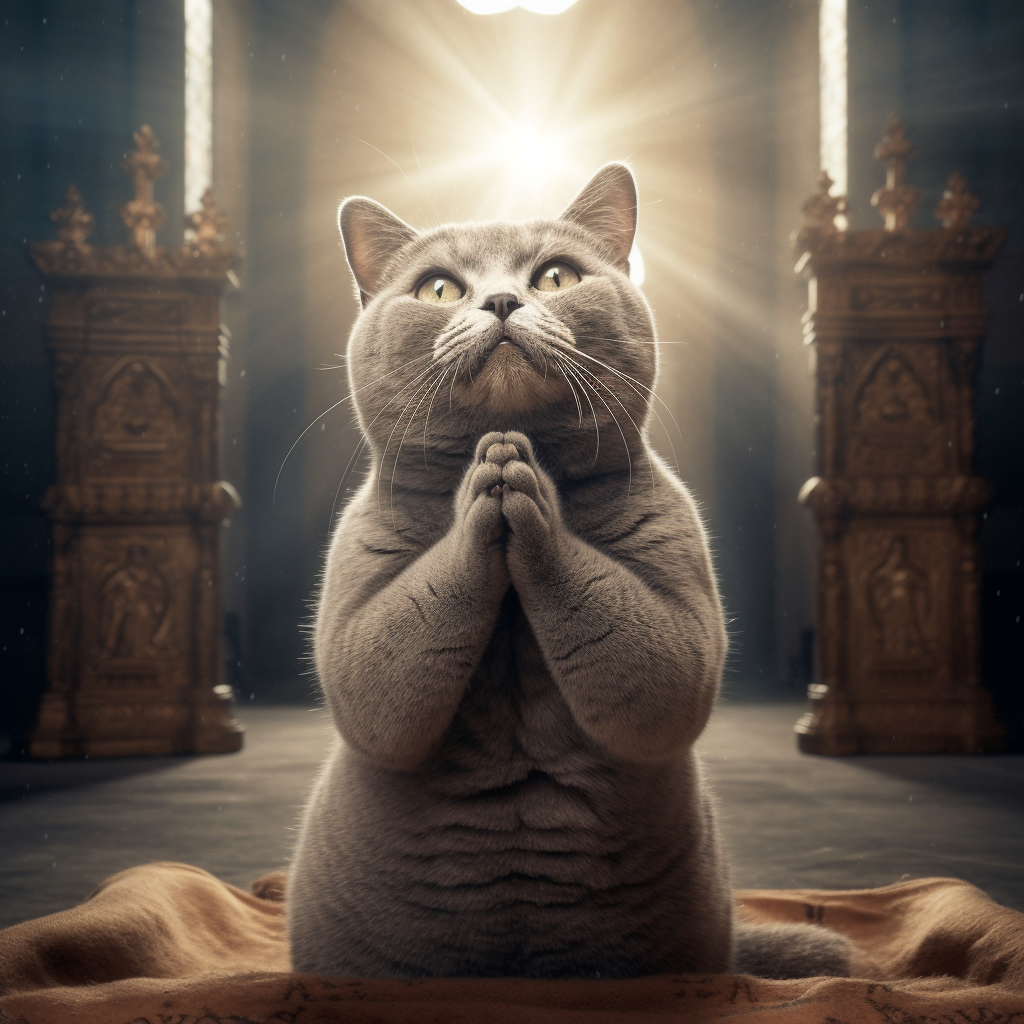

In [5]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers.utils import load_image
import torch

# 这里我将祈祷的猫咪图像提前上传到图床获取可用链接；你可以根据实际需求替换为你自己的图片
image = load_image(
    "https://ice.frostsky.com/2023/08/19/7a93c14f96e2ea8b3a4b6911fff134a1.png"
)

image

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


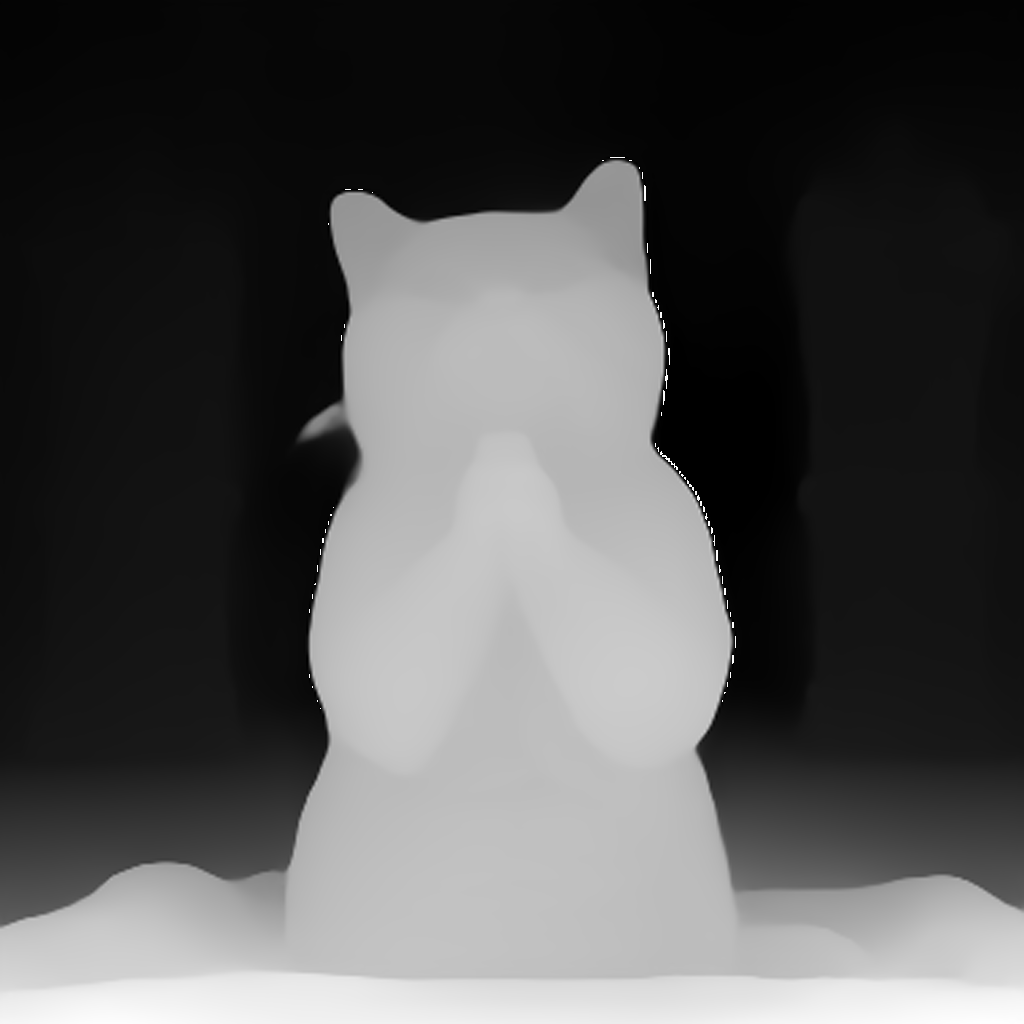

In [6]:
import cv2
import numpy as np
from PIL import Image
from transformers import pipeline

# 提取depth信息
depth_estimator = pipeline('depth-estimation')
image = depth_estimator(image)['depth']
image = np.array(image)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
control_image = Image.fromarray(image)
control_image

In [7]:
# 加载ControlNet1.1的depth模型
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth")
pipeline = StableDiffusionControlNetPipeline.from_pretrained(
	"runwayml/stable-diffusion-v1-5", controlnet=controlnet
)
pipeline.enable_model_cpu_offload()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [8]:
prompt = ["a praying cat, cartoon style, best quality, (8k, best quality, masterpiece:1.2)"] * 2
generator = torch.manual_seed(0)
image = pipeline(prompt, num_inference_steps=30, generator=generator, image=control_image, height = 512, width = 512).images

# image.save('image_out.png')

  0%|          | 0/30 [00:00<?, ?it/s]

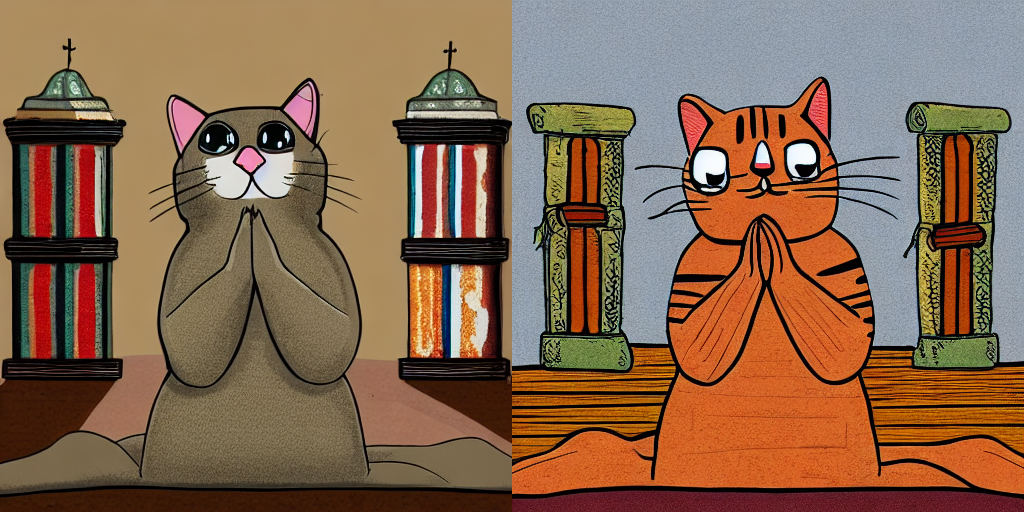

In [9]:
# 用于展示图片
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

image_grid(image, 1, 2)